# Discover project Ames housing data

# Aanpak van dit project

## Door: Eric Ruis, Laurence Frank

Eerste fase is het begrijpen van de data set. Wat betekenen de variabelen (domein kennis)? Hoe zijn de variablen verdeeld? Zijn er missende waarden, outliers? Welke variabelen correleren met elkaar en met de uitkomst maat?



## Business Understanding

Het doel is om de prijs van huizen te voorspellen op basis van een tachtigtal kenmerken van de huizen. 



## Data Understanding

De data staan uitgebreid beschreven op deze Kaggle webpagina: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


De data set bestaat uit 80 variabelen die verschillende aspecten van het huis beschrijven in de volgende categorieen: de kenmerken van het huis zelf (indeling, oppervlak, stijl, bouwjaar, kwaliteit, etc), kenmerken van de grond waarop het huis staat en kenmerken van de buurt. 

Op basis van de betekenis van de variabelen, besluiten we de volgende variabelen uit te sluiten van de analyses:

Condition2: Proximity to various conditions (if more than one is present)
Deze variabele gaat waarschijnlijk niet veel informatie toevoegen ten opzichte van Condition1.


We beginnen met een setup van python met de meest gebruikte libraries.

In [59]:
# PEP-8: group imports from standard library first, alphabetical order
from pathlib import Path # use pathlib for working with paths
import sys
import tarfile
import warnings

# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Initialize the random number generator at a specific state to be able reproduce
# the random selections in this notebook
np.random.seed(42)


**Importeren van de data**

In [86]:
ames = pd.read_csv("https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true")
ames.shape

(2930, 82)

In [61]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

dropvars = ["Condition 1", "Condition 2", "BsmtFin Type 1", "BsmtFin Type 2", "Bsmt Qual", "Bsmt Cond", 
            "Bsmt Exposure", "Pool QC", "Fence", "Misc Feature", "Alley", "Heating", "Heating QC", 
            "Central Air", "Electrical", "Functional"]

ames.drop(dropvars, axis=1, inplace=True)  # Let op: vergeet inplace=True niet 
                                           # om aan te geven dat de verandering
                                           # in de dataframe en dat de oude versie door 
                                           # de nieuwe moet worden vervangen.
#ames = ames.drop(dropvars, axis=1)
    
ames.info()

We ontdekken dat de training data set 80 variabelen bevat, terwijl de orginele data set er 82 heeft. We besluiten om zelf een training / test data set te maken met een verdeling van 70% (training) en 30% (test). 

In [87]:
traindata = ames.sample(frac = 0.7, random_state = 1)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2126 to 502
Data columns (total 82 columns):
Order              2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1706 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              141 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         

We hebben nu de training data set aangemaakt, maar nu moeten we nog de test set construeren en die bestaat uit de resterende 30% van de rijen van de originele data set. Maar hoe ga je die nu uit de originele data set halen? Dat kan wel, met een identifierende variabele, bijvoorbeeld het object nummer, `PID` in de data set. Maar dat is wat omslachtig. We kunnen ook gewoon de ingebouwde funcite `train_test_split` gebruiken. 

In [88]:
# Maak training data set en test set.
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(ames, test_size=0.3)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 1172 to 1560
Data columns (total 82 columns):
Order              2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1701 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              137 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style        

In [89]:
traindata.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1172,1173,533217050,160,FV,24.0,2160,Pave,Pave,Reg,Lvl,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,160000
1584,1585,916460060,20,RL,NaN,7915,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,195000
965,966,916455070,20,RL,NaN,6853,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,220000
1055,1056,528110080,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402
416,417,527455080,160,RL,24.0,2364,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,138000


In [90]:
testdata.shape

(879, 82)

In [91]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 753 to 1653
Data columns (total 82 columns):
Order              879 non-null int64
PID                879 non-null int64
MS SubClass        879 non-null int64
MS Zoning          879 non-null object
Lot Frontage       739 non-null float64
Lot Area           879 non-null int64
Street             879 non-null object
Alley              61 non-null object
Lot Shape          879 non-null object
Land Contour       879 non-null object
Utilities          879 non-null object
Lot Config         879 non-null object
Land Slope         879 non-null object
Neighborhood       879 non-null object
Condition 1        879 non-null object
Condition 2        879 non-null object
Bldg Type          879 non-null object
House Style        879 non-null object
Overall Qual       879 non-null int64
Overall Cond       879 non-null int64
Year Built         879 non-null int64
Year Remod/Add     879 non-null int64
Roof Style         879 non-null object
Roo

In [68]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 66 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       2930 non-null object
Exterior 2nd       2

## Checking the missing values

Visualize missing values of a `pandas` data frame: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

Another package to explore missing value patterns: missingno

see: https://github.com/ResidentMario/missingno

https://www.kaggle.com/jpmiller/patterns-of-missing-data




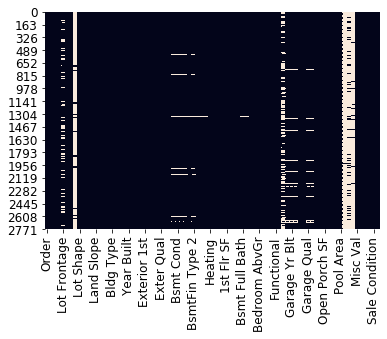

In [92]:
sns.heatmap(ames.isnull(), cbar=False)

In [93]:
ames.describe(exclude = np.object)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [94]:
ames.describe(include = np.object)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,...,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,...,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,...,1731,1231,2615,2665,2652,4,330,95,2536,2413


Verdeling van de uitkomst variabele, `SalePrice` bekijken. 

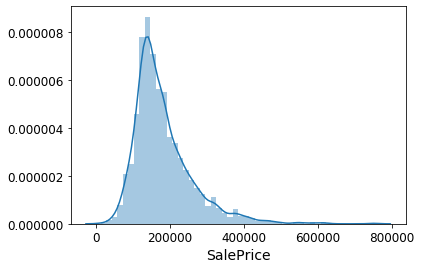

In [72]:
sns.distplot(ames['SalePrice'])

Het is duidelijk dat de verkoop prijs scheef verdeeld is. In de modelering fase nemen we de log van deze variabele. 

In [73]:
ames['SalePrice'].skew()

1.7435000757376466

## Missende waarden aanpassen



In [74]:
# dit is een probeersel
#traindata_obj = traindata.select_dtypes(include=['object'])
#traindata_obj.info()


In [75]:
#traindata_obj.head()

Nog een probeersel: kijken of we alle NaN's in objecten kunnen vervangen door '100'. We proberen dit op de kolom `Alley`.

In [76]:
#traindata_obj['Alley'].fillna('100', inplace = True)
#traindata_obj.head()

In [95]:
traindata.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1172,1173,533217050,160,FV,24.0,2160,Pave,Pave,Reg,Lvl,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,160000
1584,1585,916460060,20,RL,NaN,7915,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,195000
965,966,916455070,20,RL,NaN,6853,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,220000
1055,1056,528110080,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402
416,417,527455080,160,RL,24.0,2364,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,138000


Nu gaan we echt programmeren. Deze functie vervangt voor categorische variabelen de NaN door de waarde '100' (string) en voor numerieke variabelen de NaN door de mediaan van de betreffende variabele. 

In [96]:
columns = list(traindata)
for i in columns:
    datatype = traindata.dtypes[i]
    if datatype == "object":
        traindata[i].fillna('100', inplace = True)
    else:
        traindata[i].fillna(traindata[i].median(), inplace = True)
        
traindata.head()        
#traindata.info()       

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1172,1173,533217050,160,FV,24.0,2160,Pave,Pave,Reg,Lvl,...,0,100,100,100,0,3,2008,WD,Normal,160000
1584,1585,916460060,20,RL,68.0,7915,Pave,100,IR1,Lvl,...,0,100,100,100,0,12,2008,WD,Normal,195000
965,966,916455070,20,RL,68.0,6853,Pave,100,IR1,Lvl,...,0,100,100,100,0,6,2009,WD,Normal,220000
1055,1056,528110080,20,RL,107.0,13891,Pave,100,Reg,Lvl,...,0,100,100,100,0,1,2008,New,Partial,372402
416,417,527455080,160,RL,24.0,2364,Pave,100,Reg,Lvl,...,0,100,100,100,0,4,2009,WD,Normal,138000


Check of het gelukt is.

## Variabelen exploreren en beschrijven



Beschrijvende statistieken van de training data set. Bekijk de verdeling van de uitkomst variabele in verschillende subgroepen, zoals buurt, staat van het huis, type woning, Condition2

In [97]:
traindata.keys()

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

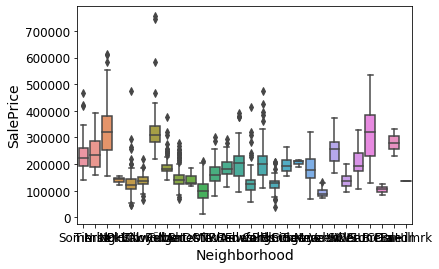

In [98]:
ax = sns.boxplot(x="Neighborhood", y="SalePrice", data=traindata)

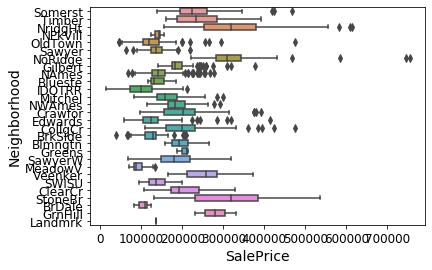

In [99]:
ax = sns.boxplot(x="SalePrice", y="Neighborhood", data=traindata, orient="h")

f = plt.figure(figsize=[2,6])
ax = f.add_subplot(111)
sns.boxplot(data=df, ax=ax)
ax.set_ylabel(ylabel='Mean Absolute Angle Error [°]',fontsize=13)
plt.tick_params(axis='y',which='both',labelleft='on',labelright='on')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_xticklabels(), rotation=90)
f.tight_layout()

In [82]:
#f, ax = plt.subplots(figsize=(12, 9))
#sns.boxplot(x="SalePrice", y="House Style", data=traindata, orient="h", ax=ax)



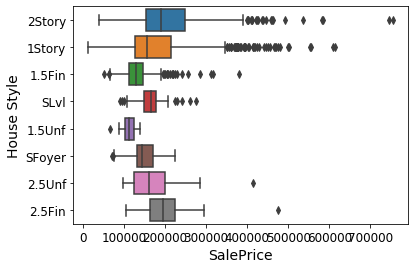

In [100]:
ax = sns.boxplot(x="SalePrice", y="House Style", data=traindata, orient="h")

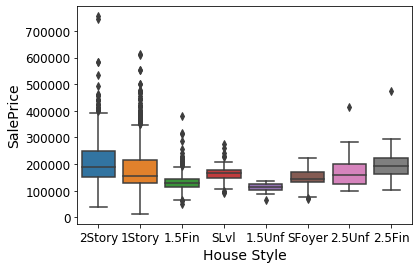

In [101]:
ax = sns.boxplot(x="House Style", y="SalePrice", data=traindata, orient="v")

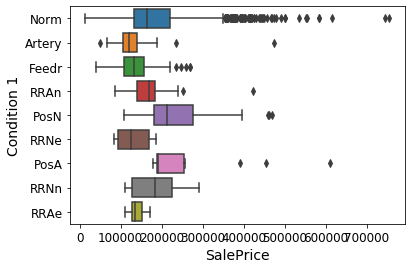

In [102]:
ax = sns.boxplot(x="SalePrice", y="Condition 1", data=traindata, orient="h")

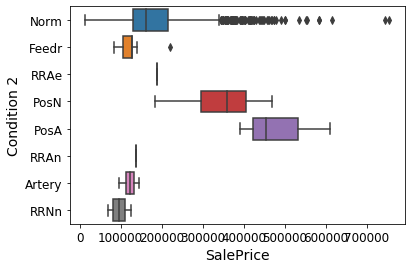

In [103]:
ax = sns.boxplot(x="SalePrice", y="Condition 2", data=traindata, orient="h")

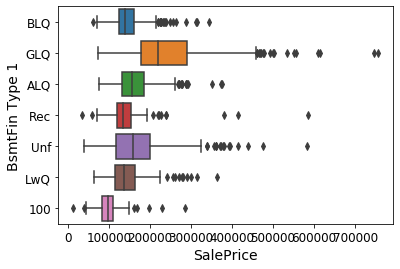

In [104]:
ax = sns.boxplot(x="SalePrice", y="BsmtFin Type 1", data=traindata)

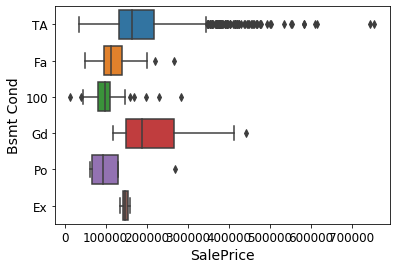

In [105]:
ax = sns.boxplot(x="SalePrice", y="Bsmt Cond", data=traindata, orient="h")

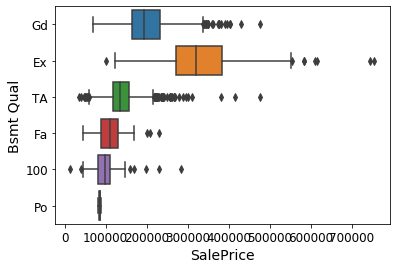

In [106]:
ax = sns.boxplot(x="SalePrice", y="Bsmt Qual", data=traindata, orient="h")

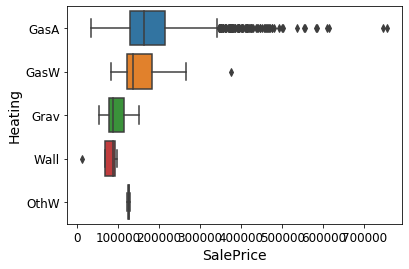

In [107]:
ax = sns.boxplot(x="SalePrice", y="Heating", data=traindata, orient="h")

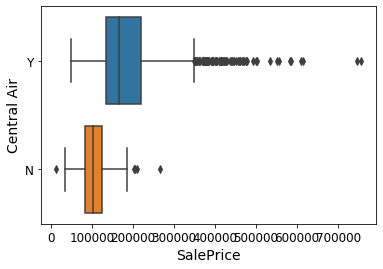

In [108]:
ax = sns.boxplot(x="SalePrice", y="Central Air", data=traindata, orient="h")

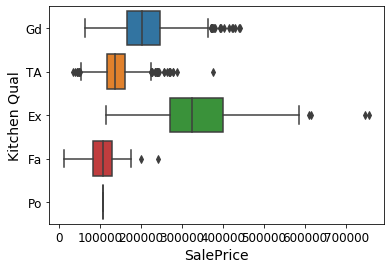

In [109]:
ax = sns.boxplot(x="SalePrice", y="Kitchen Qual", data=traindata, orient="h")

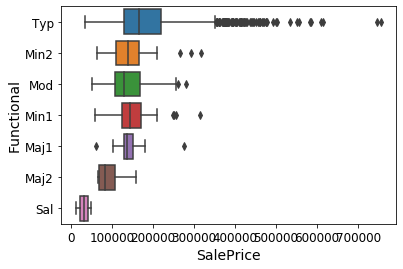

In [110]:
ax = sns.boxplot(x="SalePrice", y="Functional", data=traindata, orient="h")

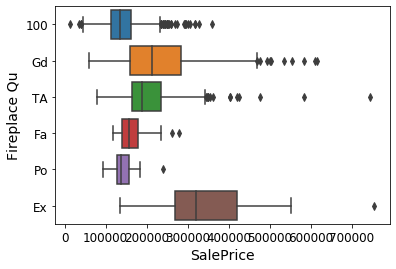

In [111]:
ax = sns.boxplot(x="SalePrice", y="Fireplace Qu", data=traindata, orient="h")

In [ ]:
min(traindata["Fireplaces"])

In [ ]:
max(traindata["Fireplaces"])

### Variabelen weglaten uit de analyses

Er worden een aantal categorische variabelen niet meegenomen omdat we bij het exploreren van de boxplots hebben gezien dat deze variabelen niet veel verband lijken te hebben met de uitkomst variabele SalesPrice.
Ook laten we de variabelen `Order` en `PID` weg omdat dit administratieve nummers van de huizen zijn, die geen relatie hebben met de uitkomst maat.

In [112]:
ames.keys()

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [113]:
dropvars = ["Order", "PID", "Condition 1", "Condition 2", "BsmtFin Type 1", "BsmtFin Type 2", "Bsmt Qual", "Bsmt Cond", 
            "Bsmt Exposure", "Pool QC", "Fence", "Misc Feature", "Alley", "Heating", "Heating QC", 
            "Central Air", "Electrical", "Functional"]

ames.drop(dropvars, axis=1, inplace=True)  # Let op: vergeet inplace=True niet 
                                           # om aan te geven dat de verandering
                                           # in de dataframe en dat de oude versie door 
                                        # de nieuwe moet worden vervangen.

# Een alternatieve manier is om het restultaat van drop() weer weg te schrijven naar ames,
# waardoor de oude data set wordt overschreven met de data set die minder variabelen bevat.
#ames = ames.drop(dropvars, axis=1)
    
ames.info()  ## check of de variabelen

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 64 columns):
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       2930 non-null object
Exterior 2nd       2930 non-null object
Mas Vnr Type       2907 non-null object
Mas Vnr Area      

We maken opnieuw een train/test data aan.

In [114]:
# Maak training data set en test set.
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(ames, test_size=0.3)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 197 to 254
Data columns (total 64 columns):
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1706 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2051 non-null object
Exterior 1st       2051 non-null object
Exterior 2nd       2051 non-null object
Mas Vnr Type       2036 non-null object
Mas Vnr Area     

## Vervang missende waarden

In [121]:
columns = list(traindata)
for i in columns:
    datatype = traindata.dtypes[i]
    if datatype == "object":
        traindata[i].fillna('100', inplace = True)
    else:
        traindata[i].fillna(traindata[i].median(), inplace = True)
        
traindata.head()        
#traindata.info() 

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
197,50,RM,50.0,6000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,48,0,0,0,0,3,2010,WD,Normal,139900
1270,20,RL,80.0,8000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2008,WD,Normal,159000
2677,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,11,2006,ConLI,Abnorml,75000
1213,80,RL,82.0,9020,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,6,2008,WD,Normal,168500
964,80,RL,125.0,14419,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,7,2009,WD,Normal,213500


In [127]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 197 to 254
Data columns (total 64 columns):
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       2051 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2051 non-null object
Exterior 1st       2051 non-null object
Exterior 2nd       2051 non-null object
Mas Vnr Type       2051 non-null object
Mas Vnr Area     

We vragen een correlatie heatmap op van de gehele training data set. We kiezen voor een heatmap vanwege het grote aantal variabelen (82).

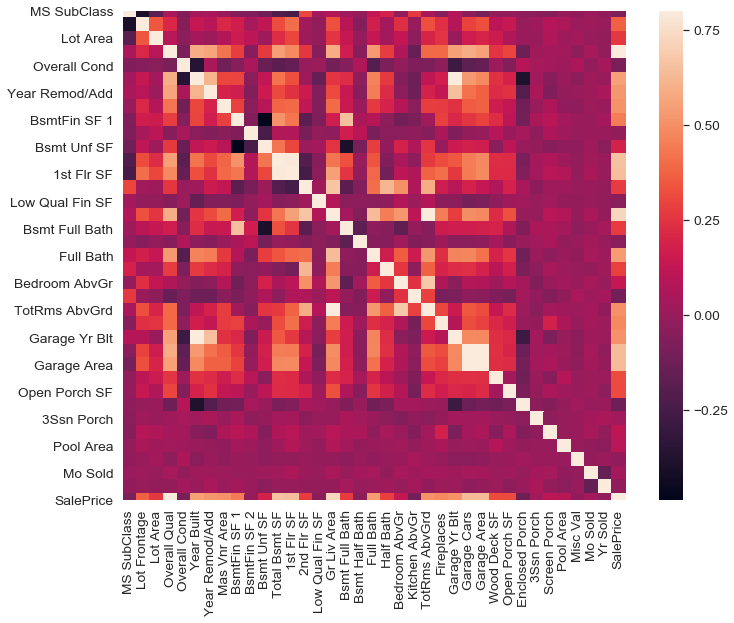

In [125]:
corrmat = traindata.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# we zouden hier alleen de correlaties tussen continue variabelen moeten opvragen 
# (en evt binair gecodeerde 0,1 variabelen).

In [116]:
traindata_numeric = traindata.select_dtypes(exclude=[np.object])

In [117]:
traindata_numeric.shape

(2051, 37)

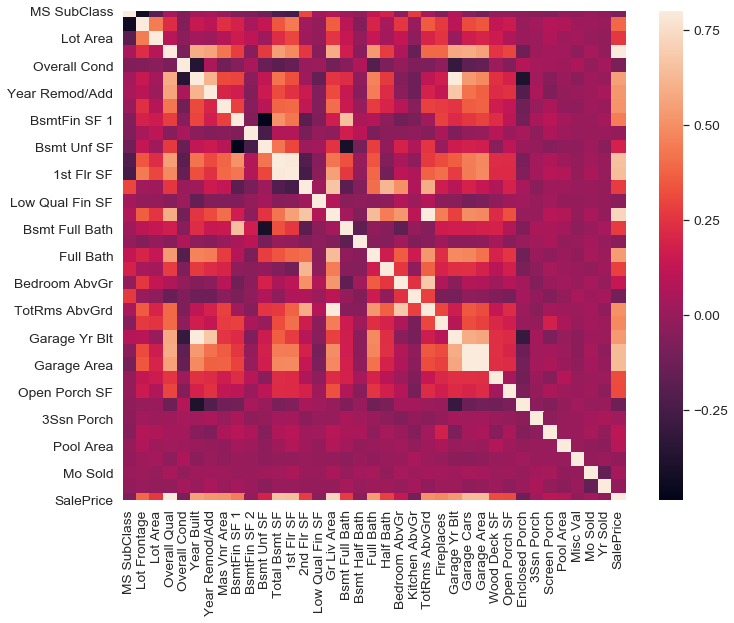

In [126]:
corrmat2 = traindata_numeric.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True);

Vooraf selecteren van de continue variabelen blijkt niet nodig te zijn: de functie correlatie doet dit kennelijk als default. 

**Conclusies van de correlatiematrix**

De volgende variabelen hebben een hoge correlatie met SalePrice:
`Overall Qual`, `Year Built`, `Year Remod/Add`, `Total Bsmt SF`, `1st Flr SF`, `Gr Liv Area`, `Garage Cars`, `Garage Area`

De correlaties zijn overwegend positief, er zijn een aantal hoge positieve correlaties (> 0.75), maar er zijn geen hoge negatieve correlaties en relatief minder negatieve correlaties. 

Verder valt op dat er een aantal predictoren onderling hoge correlaties hebben:
`Garage Year Blt` en `Year Built`;
`Gr. Liv Area` en `TotRms AbvGrd`;
`Garage Cars` en `Garage Area`;
`1st Flr SF` en `Total Bsmt SF`.


Het is toch lastig om in de heatmap een aantal variabelen te selecteren met die een hoge correlatie hebben met de uitkomst maat. Daarom een heatmap van de 10 grootste correlaties. 

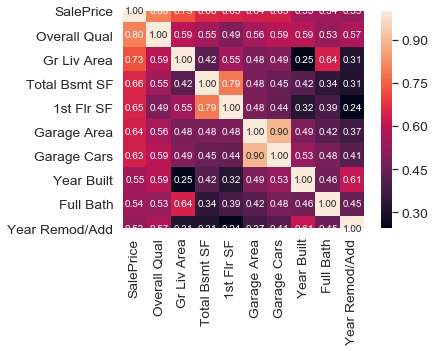

In [124]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We inspecteren de verdeling van de continue variabelen die voorkomen in de vorige heatmap plot van de 10 hoogste correlaties met de uitkomst maat. 

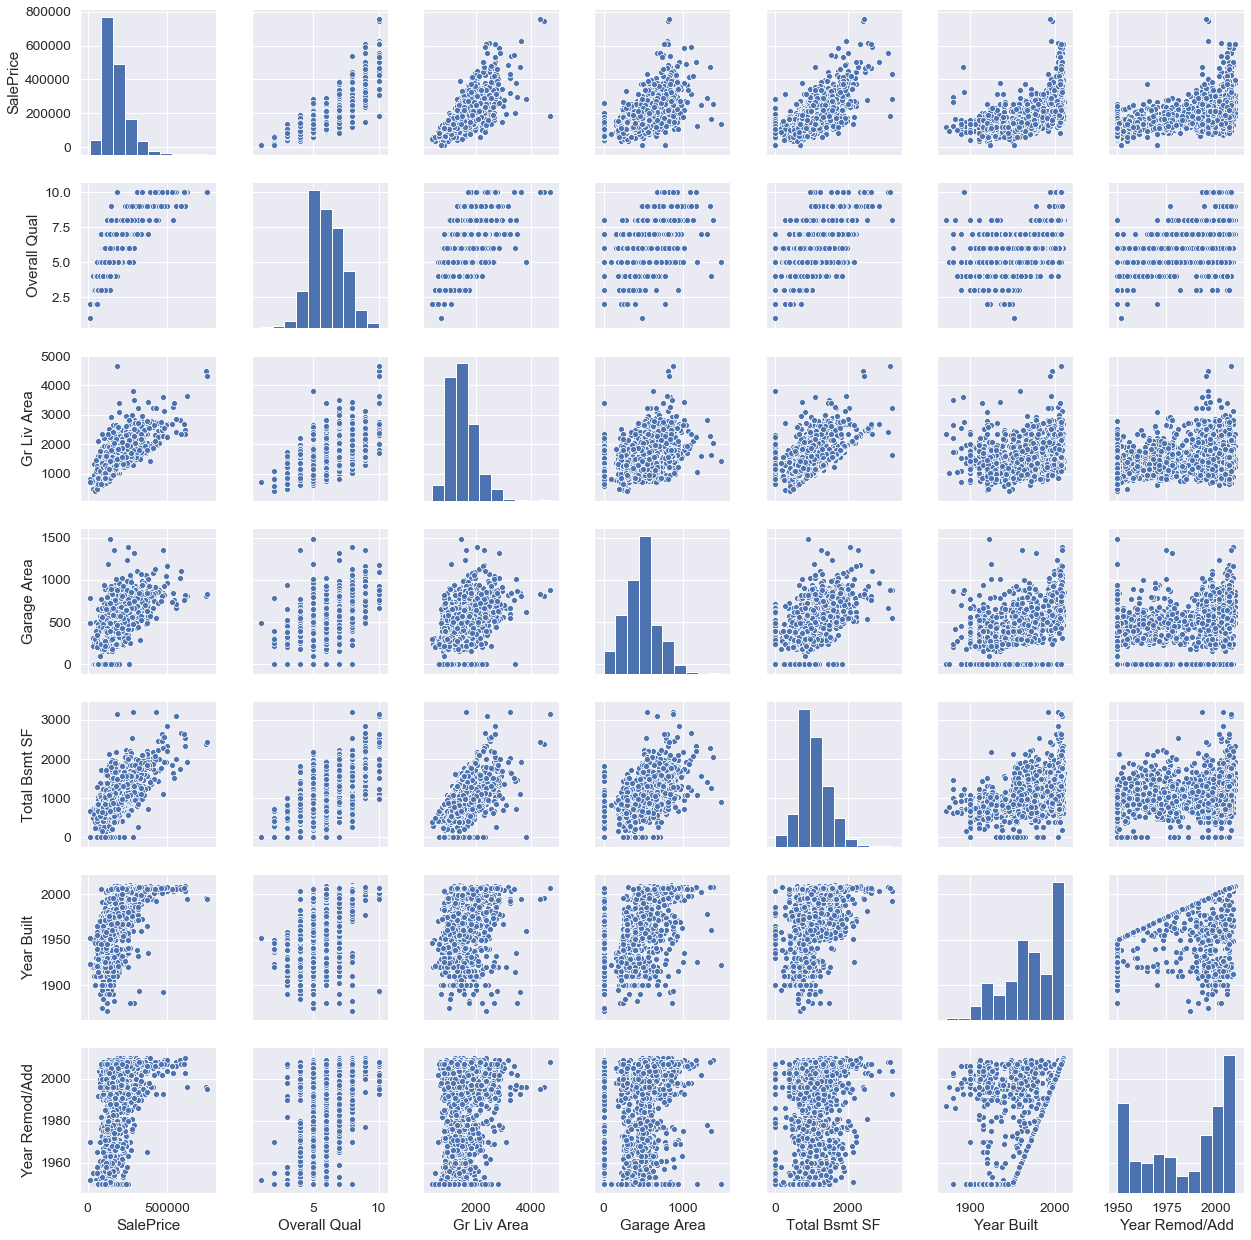

In [120]:
sns.pairplot(traindata[['SalePrice','Overall Qual','Gr Liv Area','Garage Area','Total Bsmt SF',
                        'Year Built', 'Year Remod/Add']]);